# Synthetic gravity waves

This notebook details how to use the `synthetic_gravity_waves` package to generate 2D uniformly gridded synthetic gravity waves and how to control the gravity wave packet characteristic size and carrier-wave wavelength. The basic usage as well as a walk-through of the algorithm is given below.

In [1]:
%load_ext lab_black

In [2]:
import synthetic_gravity_waves as sgw
import matplotlib.pyplot as plt
import numpy as np

## Basic usage

In [3]:
?sgw.make_synthetic_gravity_wave_composite

Signature:
sgw.make_synthetic_gravity_wave_composite(
    N=512,
    r_sigma=5,
    lw0=20.0,
    r0=100,
    return_envelope=False,
)
Docstring:
On a 2D unit-grid of `(N,N)` points create a amplitude composite of
randomly oriented synthetic gravity waves with each gravity wave packet
having a 2D Gaussian envelope with characteristic size `r0` (and spaced by
`2*r0` to aviod overlap) and carrier wave wavelength uniformly sampled in
`[0, lw0]` and envelope size aspect ratio normally distributed (mean=0.5,
sigma=0.5).
File:      ~/Desktop/wavelet/synthetic_gravity_waves/composite.py
Type:      function


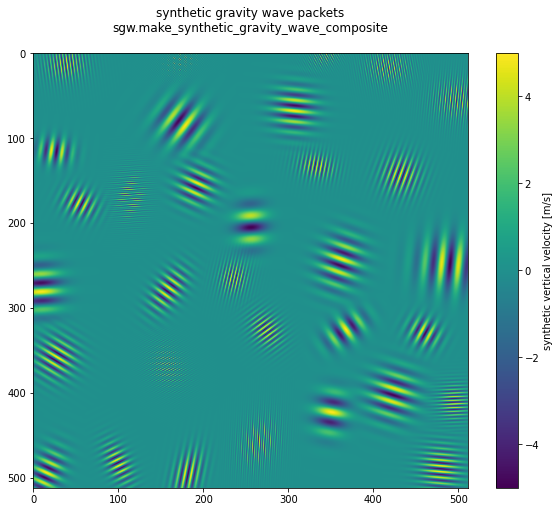

In [4]:
w0 = 5.0  # max characteristc vertical velocity [m/s]
phi = sgw.make_synthetic_gravity_wave_composite(N=512, r_sigma=10.0, r0=80.0, lw0=10.0)

w = phi * w0
fig, ax = plt.subplots(figsize=(10, 8))
g = ax.imshow(w)
cb = plt.colorbar(g, ax=ax)
cb.set_label("synthetic vertical velocity [m/s]")
ax.set_title(
    """synthetic gravity wave packets
sgw.make_synthetic_gravity_wave_composite
"""
)
fig.savefig("synthetic_gravity_waves_vertical_velocity_example.png")

## Breakdown of algorithm

### 1. Modified Poisson disc sampling

First the locations of the synthetic gravity wavepackets must be generated, the centers of the wave-packets. This is done by using a methed based on the Poisson-disc sampling algorithm by [Robert Bridson](http://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf), but modified to in place of using a 2D density field to define the local density of points the spatial separation between points is sampled from a Gaussian distribution with mean `r0` and standard deviation `r_sigma`. The sampling is done on a grid of shape `(N, N)`.

In [5]:
?sgw.modified_poisson_disk_sampling

Signature:
sgw.modified_poisson_disk_sampling(
    N=100,
    r0=10,
    r_sigma=1,
    k=50,
    radiusType='default',
)
Docstring:
Implementation of the Poisson Disk Sampling algorithm, but modified so that for each
point added the radius between points is sampled from a Gaussian distribution

:param N: grid size in number of pixels (assumed square domain)
:param r0: length-scale for distance between points
:param r_sigma: std div for distance between points
:param k: Number of iterations to use to place a new point before giving up
:return: nParticle: Number of particles in the sampling.
         particleCoordinates: 2d array containing the coordinates of the created particles.
         radii: radii for the sampled particles

based on https://gitlab.com/abittner/poissondisksampling/-/blob/master/poissonDiskSampling/bridsonVariableRadius.py
File:      ~/Desktop/wavelet/synthetic_gravity_waves/point_sampling.py
Type:      function


(257, 46.921890804460745, 5.325517532527252)

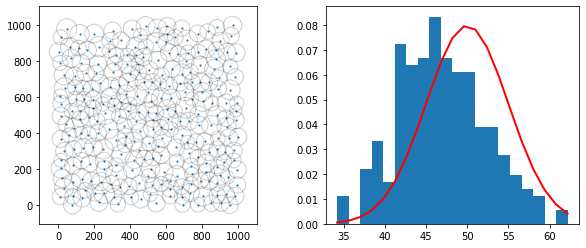

In [6]:
N = 1000
r_sigma = 5
r0 = 50

x, y = np.meshgrid(np.arange(N), np.arange(N), indexing="xy")

(
    n_pts,
    pts,
    radii,
) = sgw.modified_poisson_disk_sampling(N=N, r0=r0, r_sigma=r_sigma)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
ax = axes[0]
ax.scatter(pts[:, 0], pts[:, 1], marker=".", s=5)
for i in range(pts.shape[0]):
    ax.add_patch(
        plt.Circle(
            xy=pts[i, :],
            radius=radii[i],
            facecolor="none",
            edgecolor="black",
            alpha=0.2,
        )
    )
ax.set_aspect(1)

ax = axes[1]

count, bins, ignored = ax.hist(radii, 20, density=True)
ax.plot(
    bins,
    1
    / (r_sigma * np.sqrt(2 * np.pi))
    * np.exp(-((bins - r0) ** 2) / (2 * r_sigma**2)),
    linewidth=2,
    color="r",
)

n_pts, np.mean(radii), np.std(radii)

## 2. Place Gaussian wave-envelopes at sampled points

With the sampling points defined we now need a way to create the gravity wave packet envelope at a given location `(x0, y0)` and given x/y-size `(sigma_x, sigma_y)` and orientation `theta`:

In [7]:
?sgw.make_gaussian_2d

Signature: sgw.make_gaussian_2d(x0=0, y0=0, theta=0, sigma_x=10, sigma_y=10)
Docstring:
Return a function of `(x, y)` that evaluates the value of a 2D Gaussian
distribution centered on `(x0, y0)` and std.div. in x- and
y-directions `sigma_x` and `sigma_y` rotated by angle `theta` in degrees
File:      ~/Desktop/wavelet/synthetic_gravity_waves/components.py
Type:      function


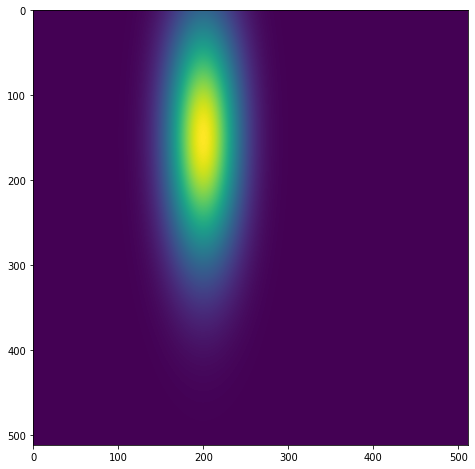

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

fn_wavepacket = sgw.make_gaussian_2d(x0=150, y0=200, sigma_x=100, sigma_y=30, theta=0.0)

N = 512
x, y = np.meshgrid(np.arange(N), np.arange(N), indexing="ij")
phi = fn_wavepacket(x, y)

ax.imshow(phi)

## 3. Modulate carrier wave by wave packet envelope

Next we create a plane parallel wave with wavelength `lw` oriented in direction with and modulated by the envelope. Together that becomes:

In [9]:
?sgw.make_2d_wavepacket

Signature: sgw.make_2d_wavepacket(x0, y0, lx, ly, theta, lw)
Docstring:
Return a function of `(x,y)` which produces the amplitude of a plane-parallel sinosoidal wave with wavelength `lw` and orientation angle `theta` modulated by a 2D Gaussian envelope centered on `(x0, y0)` of characteristic widths `(lx, ly)`
oriented with width `lx` along the direction angle `theta`.

In summary:
    (x0, y0): position of wavepacket
    (lx, ly): x- and y- length-scale of wavepacket
    theta: orientation of wavepacket and sinosoidal carrier wave [deg]
    lw: length-scale of gravity "carrier wave"
File:      ~/Desktop/wavelet/synthetic_gravity_waves/components.py
Type:      function


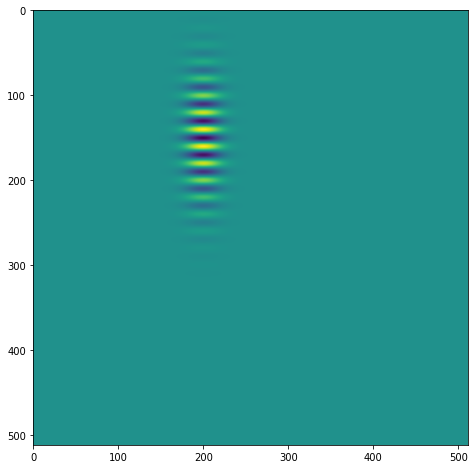

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

fn_wavepacket = sgw.make_2d_wavepacket(x0=150, y0=200, lx=100, ly=30, theta=0.0, lw=20)

N = 512
x, y = np.meshgrid(np.arange(N), np.arange(N), indexing="ij")
phi = fn_wavepacket(x, y)

ax.imshow(phi)

## 4. Use point-sampling to fill domain

Finally, we put all these pieces together to create points with modified Poisson-disc sampling and place synthetic gravity wave packets with characteristics controlled by a characterisic size `r0` (and stddiv `r_sigma`), carrier-wave wavelength `lw0`.

In [11]:
?sgw.make_synthetic_gravity_wave_composite

Signature:
sgw.make_synthetic_gravity_wave_composite(
    N=512,
    r_sigma=5,
    lw0=20.0,
    r0=100,
    return_envelope=False,
)
Docstring:
On a 2D unit-grid of `(N,N)` points create a amplitude composite of
randomly oriented synthetic gravity waves with each gravity wave packet
having a 2D Gaussian envelope with characteristic size `r0` (and spaced by
`2*r0` to aviod overlap) and carrier wave wavelength uniformly sampled in
`[0, lw0]` and envelope size aspect ratio normally distributed (mean=0.5,
sigma=0.5).
File:      ~/Desktop/wavelet/synthetic_gravity_waves/composite.py
Type:      function


Below the code from `sgw.make_synthetic_gravity_wave_composite` are reproduced so that we can plot each step separately:

In [12]:
N = 512
r_sigma = 5
lw0 = 20.0
r0 = 100

phi = np.zeros((N, N))
phi_envelope = np.zeros((N, N))

for pt, r in zip(pts, radii):
    theta = 180 * np.random.uniform()
    lw = lw0 * np.random.normal()
    a = 0.5 + 0.5 * np.random.uniform()

    lx = r / 2
    ly = a * r / 2
    x0, y0 = pt

    fn_envelope = sgw.make_gaussian_2d(
        x0=x0, y0=y0, theta=theta, sigma_x=lx / 2, sigma_y=ly / 2
    )
    phi_envelope += fn_envelope(x, y)

    fn_wavepacket = sgw.make_2d_wavepacket(
        x0=x0, y0=y0, lx=lx, ly=ly, theta=theta, lw=lw
    )
    phi += fn_wavepacket(x, y)

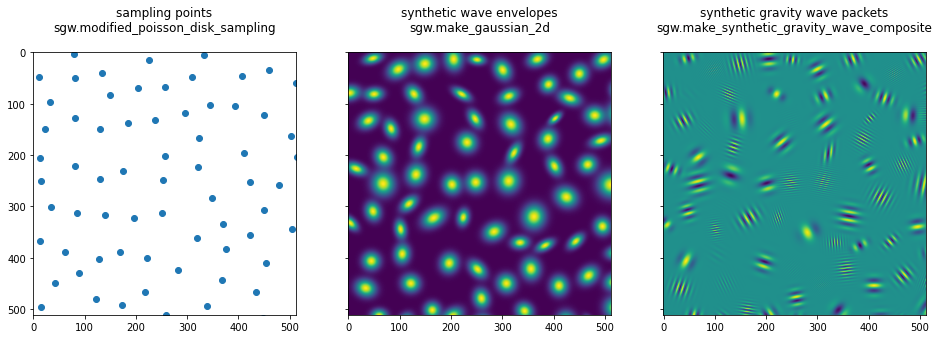

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6), sharey=True, sharex=True)
ax = axes[0]
ax.scatter(pts[:, 0], pts[:, 1])
ax.set_title(
    """sampling points
sgw.modified_poisson_disk_sampling
"""
)

ax = axes[1]
ax.imshow(phi_envelope)
ax.set_title(
    """synthetic wave envelopes
sgw.make_gaussian_2d
"""
)

ax = axes[2]
ax.imshow(phi)
ax.set_title(
    """synthetic gravity wave packets
sgw.make_synthetic_gravity_wave_composite
"""
)

[ax.set_aspect(1) for ax in axes]

fig.set_facecolor("white")

fig.savefig("synthetic_gravity_wave_envelopes.png")